In [ ]:
# RUN ONCE
#!git clone https://github.com/benckx/dnn-movie-posters.git!cd dnn-movie-posters && python3 ./get_data.py -download


In [ ]:
# RUN ONCE
# !cd dnn-movie-posters && python3 ./get_data.py -download

#!pip install pandas==0.22 --user

In [ ]:
!nvidia-smi

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
batch_size = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_buckets = 10

original_shape = [268, 182]
resize_n = 3




In [4]:
def bucketize(x):
    x = (x * 9.99).int()
    return x

In [5]:
poster_transforms = transforms.Compose([ # Compose combines a number of transforms into one operation
    transforms.Resize([original_shape[0]//resize_n, original_shape[1]//resize_n]),
    transforms.Grayscale(num_output_channels = 1),
    transforms.ToTensor(), # PIL Image -> Tensor
    transforms.Lambda(lambda x: bucketize(x)),
])

shape = [original_shape[0]//resize_n, original_shape[1]//resize_n]

In [6]:
data_path = "./dnn-movie-posters/data/images/"
val_data_path = './dnn-movie-posters/data/val/'

In [7]:
# # RUN ONCE 
# val_files = os.listdir(data_path + '100/')[-100:]
# os.makedirs(val_data_path, exist_ok=True)
# os.makedirs(val_data_path + '100/', exist_ok=True)
# for file in val_files:
#     os.rename(data_path + '100/' + file, val_data_path + '100/'+ file)


In [8]:
train_dataset = datasets.ImageFolder(data_path, transform=poster_transforms)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

val_dataset = datasets.ImageFolder(val_data_path, transform=poster_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)


In [9]:
image, _ = next(iter(train_loader))
image.shape

torch.Size([8, 1, 89, 60])

In [10]:
def plot_image(image, cmap=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(image.detach().cpu().permute(1, 2, 0).squeeze(), cmap=cmap)
    plt.show()


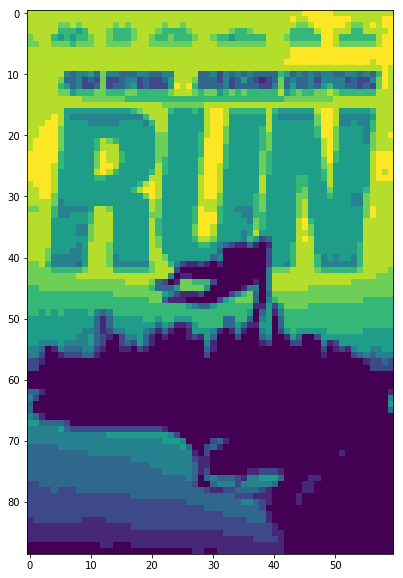

In [11]:
plot_image(image[0], cmap=None)

In [12]:
def make_mask(include_center, height, width):
    mask = torch.ones(height, width).long()
    mask[height//2][(width+include_center)//2:] = torch.zeros(width - (width+include_center)//2)
    mask[(height+1)//2:] = torch.zeros(height-(height+1)//2, width)
    return mask

In [13]:
class MaskedCNN(nn.Conv2d):
    def __init__(self, include_center, *args, **kwargs):
        """include_center (bool)"""
        super(MaskedCNN, self).__init__(*args, **kwargs)
        self.include_center = include_center
        self.register_buffer('mask', self.weight.data.clone())

        _, depth, height, width = self.weight.size()
        self.mask.fill_(1)
        self.mask[:,:] = make_mask(self.include_center, height, width )

    def forward(self, x):
        self.weight.data*=self.mask
        return super(MaskedCNN, self).forward(x)

In [15]:
class PixelCNN(nn.Module):
    def __init__(self, depth=3, input_channels=1, num_pixels=10):
        super(PixelCNN,self).__init__()
        self.layers = nn.Sequential(
            MaskedCNN(False, input_channels, 64, 7, stride=1, padding=3, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
             MaskedCNN(True, 64, 64, 5, stride = 1, padding=2, bias=True),
             nn.BatchNorm2d(64),
             nn.ReLU(),
             MaskedCNN(True, 64, 64, 5, stride=1, padding=2, bias=False),
             nn.BatchNorm2d(64),
             nn.ReLU(),
            
            MaskedCNN(True, 64, 64, 3, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, num_pixels, 1)
        )
    def forward(self, x):
        x = x.float()
        x = self.layers(x)
        return x
        
    def generate_samples(self, starting_image, starting_point=(0, 0)):
        self.eval()
        i, j = starting_point
        while i < shape[0]:
            while j < shape[1]:
                out = nn.Softmax()(self.forward(starting_image)).detach().cpu()
                starting_image[:, :, i, j] = torch.LongTensor(torch.multinomial(out[:, :, i, j], 1))
                j += 1

            i += 1
            j = 0

        return starting_image


In [16]:
def plot_losses(losses):
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.show()

In [17]:
model = PixelCNN().to(device)
model = torch.load('./model github')
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
losses = []
imgs = []
for i in range(1000):
    model.train()
    c = 0
    for ind, (image, _) in (enumerate(train_loader)):
        optimizer.zero_grad()
        image = image.to(device)
        logits = model(image)
        loss = criterion(logits, image.long().squeeze())
        loss.backward()
        optimizer.step()
    model.eval()
    image, _ = next(iter(val_loader))
    starting_image = image.clone()
    starting_image[:, :, :, :] = 0
    sample = model.generate_samples(starting_image[:1].to(device), (0, 0))
    plot_image(sample[0])
    plot_losses(losses)
    

In [ ]:
torch.save(model, './model github')

In [ ]:
model.eval()
image, _ = next(iter(val_loader))
starting_image = image.clone()
starting_image[:, :, :, :] = 0
sample = model.generate_samples(starting_image[:1].to(device), (0, 0))
plot_image(sample[0], cmap = 'gray')